### Student Name: JOHN DENNEHY
### Student Number: 14176599

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import NMF, PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import warnings

### Utility Functions

#### Read Data

In [2]:
def return_dataframe_data(file_path, index_column = None):
    """
    This function takes a file path, calls the read_csv method from pandas and returns the data
    """
    
    df = pd.read_csv(file_path, index_col=index_column)
    return df

#### Categorical counts of column values

In [3]:
def print_categorical_column_count(data_frame, column_name):
    """ This function takes a data frame and a categorical column name and prints out the different values within the column """
    
    # Add new line and divider
    print("\n" + "*" * 50)
    
    # Print out the column name in order to be able to identify
    print("\n" + "Column Count for {} column".format(column_name) + "\n")
    
    # Call value_counts method on passed data frame column name to return values within categorical column
    print(data_frame[column_name].value_counts() )
    
    # Add new line and divider
    print("\n" + "*" * 50 + "\n")

#### Plot categorical graphs

In [4]:
def plot_frequency_table_results(data_frame, column):
    """
    This function plots a frequency table for a selected column on the passed pandas data frame
    """
    
    # Construct a frequency table by calling value_counts method on passed pandas dataframe column
    frequency_table = data_frame[column].value_counts()
    
    # Plot the results in a bar chart and add labels and title
    frequency_table.plot(kind="bar")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.title("Frequency chart for {} column".format(column))
    plt.show()

#### Plot numeric graphs

In [5]:
def plot_histogram_box_plot_probability_density_violin_plot(data_frame, column):
    """ 
    This function takes a data frame and a column name and plots a histogram, box plot, probability density
    and violin plot to enable a clear view of the distribution
    """
    
    # 2x2 graphs, extract fig and each plot axis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 8))
    
    # Call hist method on the passed dataframe and column to show a histogram distribution
    # Note ax parameter is needed to position the graph
    data_frame[column].hist(bins=50, ax=ax1)
    ax1.set_title("Histogram of {}".format(column))
    ax1.set_xlabel(column)
    ax1.set_ylabel("Customers")
    
    # Call boxplot method on the passed dataframe with the column parameter as the target
    # Note ax parameter is used to position the graph
    data_frame.boxplot(column=column, ax=ax2)
    ax2.set_title("Box plot of {}".format(column))
    
    # Call kdeplot from seaborn to plot the probability density graph
    sns.kdeplot(data=data_frame, x=column, fill=True, ax=ax3)
    ax3.set_title("Probability density of {}".format(column))
    
    # Call violinplot method from seaborn to plot a violin plot of the data frame column
    sns.violinplot(data=data_frame, x=column, ax=ax4)
    ax4.set_title("Violin plot of {}".format(column))
    
    plt.tight_layout()
    plt.show()

#### Statistical info on numerical features

In [6]:
def get_largest_values(data_frame, column, number_of_values):
    """
    This function returns the largest values of a given column on a data frame
    """
    # Note nlargest method used on data frame to extract number that corresponds with number_of_values param
    return data_frame.nlargest(number_of_values, column)

In [7]:
def get_smallest_values(data_frame, column, number_of_values):
    """
    This function returns the smallest values of a given column on a data frame
    """
    
    # Note nsmallest method used on data frame to extract number that corresponds with number_of_values param
    return data_frame.nsmallest(number_of_values, column)

In [8]:
def identify_outliers_interquartile_range_method(column):
    """
    This function uses the interquartile range method to identify outliers from a given column
    
    (Q3 - Q1) * 1.5
    """
    
    # Extract first and third quarter percentile values using percentile method on numpy package
    first_quarter, third_quarter = np.percentile(column, 25), np.percentile(column, 75)
    
    # Calculate ranage by subtracting first quarter from third quarter
    inter_quartile_range = third_quarter - first_quarter
    
    # Print out the range for visualisation purposes
    print("Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f" % (first_quarter, third_quarter, inter_quartile_range))
    
    # Calculate the outlier cutoff
    cut_off = inter_quartile_range * 1.5
    
    # Identify the range for which anything outside will be considered an outlier
    lower, upper = first_quarter - cut_off, third_quarter + cut_off
    
    # Identify outliers
    outliers = [x for x in column if x < lower or x > upper]
    
    # Print out the length of identified outliers for visualisation
    print("Identified outliers: %d" % len(outliers))
    
    # Remove outliers
    outliers_removed = [x for x in column if x >= lower and x <= upper]
    
    # Print out the length of values that are not outliers for visualisation
    print("Non-outlier observations: %d" % len(outliers_removed))

In [9]:
def return_data_frame_correlation_with_column(data_frame, column):
    """
    This function identifies the correlation between columns using the corr method on the pandas data frame
    """
    
    # Define correlations variable that stores the results of calling the corr method on the passed pandas dataframe
    correlations = data_frame.corr(method="pearson")

    # The target outcome
    target_correlation = correlations[column]

    # Sort values - ascending value of false
    target_correlation_descending = target_correlation.sort_values(ascending=False)
    
    # Return the correlation with the target column
    return target_correlation_descending

#### Grid Search

In [10]:
def grid_search_with_pipeline(pipeline, param_grid, n_jobs = -1, cv = 5, refit = True):
    """
    This function conducts a grid search using the pipeline passed and the param_grid dict for the search area
    """
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            search = GridSearchCV(pipeline, param_grid, n_jobs=n_jobs, cv=cv, refit=refit)
            search.fit(X_train, y_train)

            return search
    except Exception as e:
        print("An error occurred: {}".format(e))

In [11]:
def extract_grid_search_results(grid_search_results):
    """
    This function extracts key results off of the grid search results object and returns them
    """
        
    best_score = grid_search_results.best_score_
    best_params = grid_search_results.best_params_
    best_estimator = grid_search_results.best_estimator_

    return best_score, best_params, best_estimator

#### Random Forest Decision Tree Visualisation

In [12]:
def visualise_random_forest_decision_tree(random_forest_trained_model, feature_names, number_of_iterations = 3, max_depth = 2):
    """
    This function makes use of the graphviz package to display decision trees
    """
        
    for i in range(number_of_iterations):
        print("*" * 100)
        print("Iteration: {}".format(i + 1))
        print("*" * 100)

        tree = random_forest_trained_model.estimators_[i]
        dot_data = export_graphviz(tree,
                                   feature_names=feature_names,  
                                   filled=True,  
                                   max_depth=max_depth, 
                                   impurity=False, 
                                   proportion=True)
        graph = graphviz.Source(dot_data)
        display(graph)

#### Confusion Matrix Graph

In [13]:
def plot_confusion_matrix(y, y_pred, title):
    """
    This function plots a confusion tree
    """
    
    matrix = confusion_matrix(y, y_pred)
    matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]


    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={"size":10}, linewidths=0.2)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix for Optimal {} Model".format(title))
    plt.show()

#### Random Forest Plot Most Important Features

In [14]:
def plot_random_forest_model_most_important_features(random_forest_trained_model, random_forest_model_feature_names, title = "Random Forest Model - Feature Importance"):
    """
    This function plots a bar chart with the importance of each feature to the predicted target outcome
    """
    
    feature_rankings = pd.Series(random_forest_trained_model.feature_importances_, index=random_forest_model_feature_names).sort_values(ascending=False)
    plt.title(title)
    feature_rankings.plot.bar();

#### Plot 2D result of PCA for SVM

In [15]:
def plot_svm_2d_graph(pipeline, X, y, preprocess_step = "preprocess", first_dim_reduction_name = "reduce_dim", second_dim_reduction_name = "reduce_dim_2D"):
    """
    This function plots a scatterplot of the dataset reduced to 2D (ideal target is 6D, can't visualise that)
    """
    
    X_preprocessed = pipeline["preprocess"].transform(X)
    
    X_pca = pipeline[first_dim_reduction_name].transform(X_preprocessed)
    
    X_pca_2D = pipeline[second_dim_reduction_name].transform(X_pca)
    
    plt.scatter(X_pca_2D[:, 0], X_pca_2D[:, 1], c=y, cmap="viridis")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title("Dataset after second PCA applied for visualisation")
    plt.show()


## Task 1

### Load dataset

In [16]:
df = return_dataframe_data("./insurance.csv")

### Exploratory Data Analysis

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   gender          1338 non-null   object 
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   object 
 5   region          1338 non-null   object 
 6   insurance_cost  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [18]:
df.columns

Index(['age', 'gender', 'bmi', 'children', 'smoker', 'region',
       'insurance_cost'],
      dtype='object')

In [19]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [20]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [21]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total Count of Null Values", "Percentage of Null Values"])
missing_data.head(20)

Total Count of Null Values  Percentage of Null Values
age                                      0                        0.0
gender                                   0                        0.0
bmi                                      0                        0.0
children                                 0                        0.0
smoker                                   0                        0.0
region                                   0                        0.0
insurance_cost                           0                        0.0

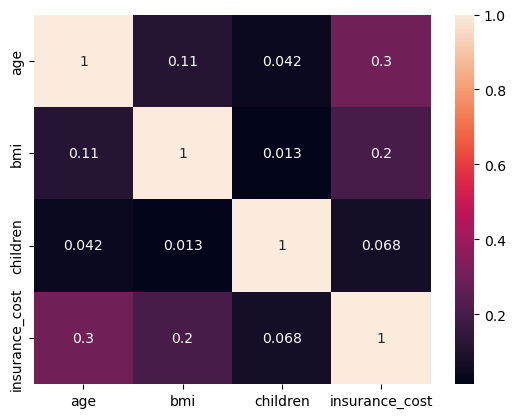

In [22]:
numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns

sns.heatmap(df[numerical_columns].corr(), annot=True);

/Users/johndennehy/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


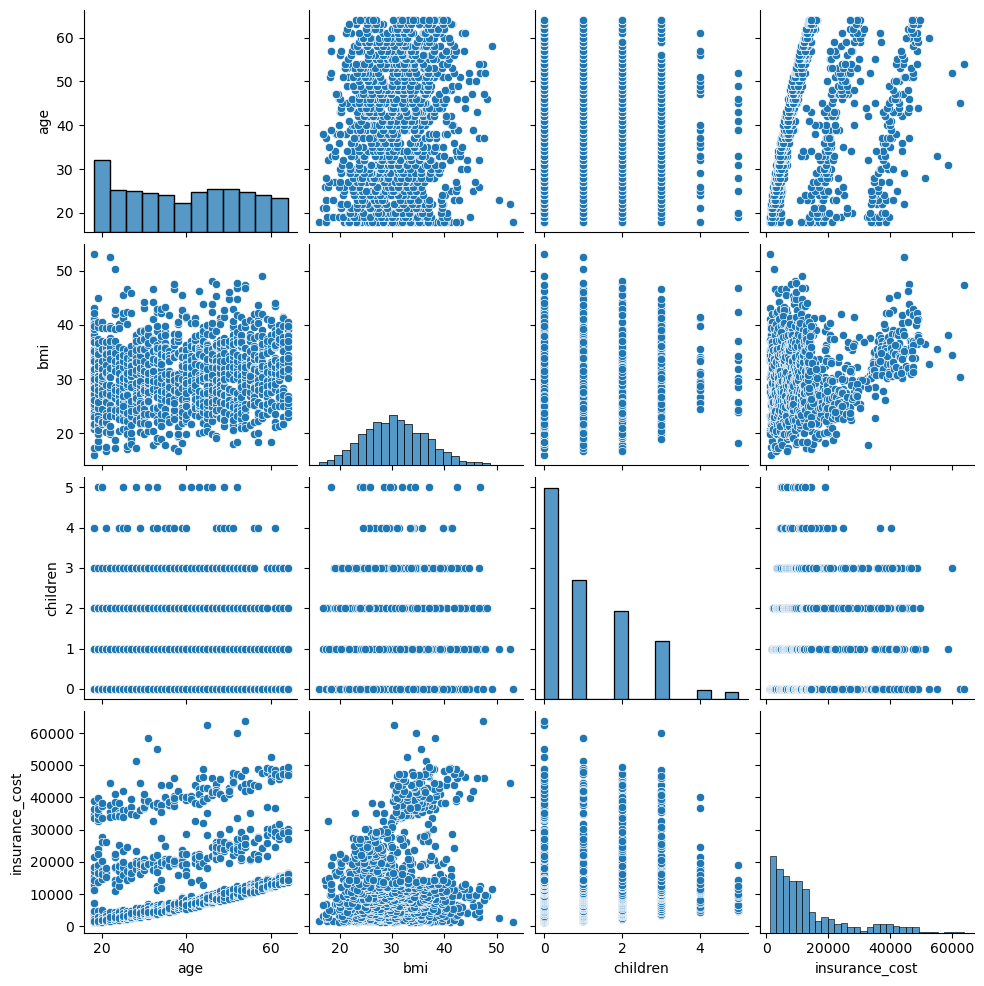

In [23]:
sns.pairplot(data=df[["age","bmi","children","insurance_cost",]].dropna())
plt.show()

#### Insurance Cost Spread

In [24]:
get_largest_values(df, "insurance_cost", 10)

age  gender     bmi  children smoker     region  insurance_cost
1079   54  female  47.410         0    yes  southeast     63770.42801
837    45    male  30.360         0    yes  southeast     62592.87309
1035   52    male  34.485         3    yes  northwest     60021.39897
458    31  female  38.095         1    yes  northeast     58571.07448
512    33  female  35.530         0    yes  northwest     55135.40209
1246   60    male  32.800         0    yes  southwest     52590.82939
363    28    male  36.400         1    yes  southwest     51194.55914
1336   64    male  36.960         2    yes  southeast     49577.66240
1221   59    male  41.140         1    yes  southeast     48970.24760
793    44  female  38.060         0    yes  southeast     48885.13561

In [25]:
get_smallest_values(df, "insurance_cost", 10)

age gender    bmi  children smoker     region  insurance_cost
47   18   male  23.21         0     no  southeast       1121.8739
41   18   male  30.14         0     no  southeast       1131.5066
60   18   male  33.33         0     no  southeast       1135.9407
35   18   male  33.66         0     no  southeast       1136.3994
1    18   male  34.10         0     no  southeast       1137.0110
12   18   male  34.43         0     no  southeast       1137.4697
43   18   male  37.29         0     no  southeast       1141.4451
39   18   male  41.14         0     no  southeast       1146.7966
22   18   male  43.01         0     no  southeast       1149.3959
66   18   male  53.13         0     no  southeast       1163.4627

####  Loop over the categorical columns list, call print_categorical_column_count utility function to view distribution

In [26]:
categorical_columns_list = ["gender", "smoker", "region"]

In [27]:
for column in categorical_columns_list:
    print_categorical_column_count(df, column)


**************************************************

Column Count for gender column

gender
male      676
female    662
Name: count, dtype: int64

**************************************************


**************************************************

Column Count for smoker column

smoker
no     1064
yes     274
Name: count, dtype: int64

**************************************************


**************************************************

Column Count for region column

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

**************************************************



####  Distribution Analysis for Numerical Attributes

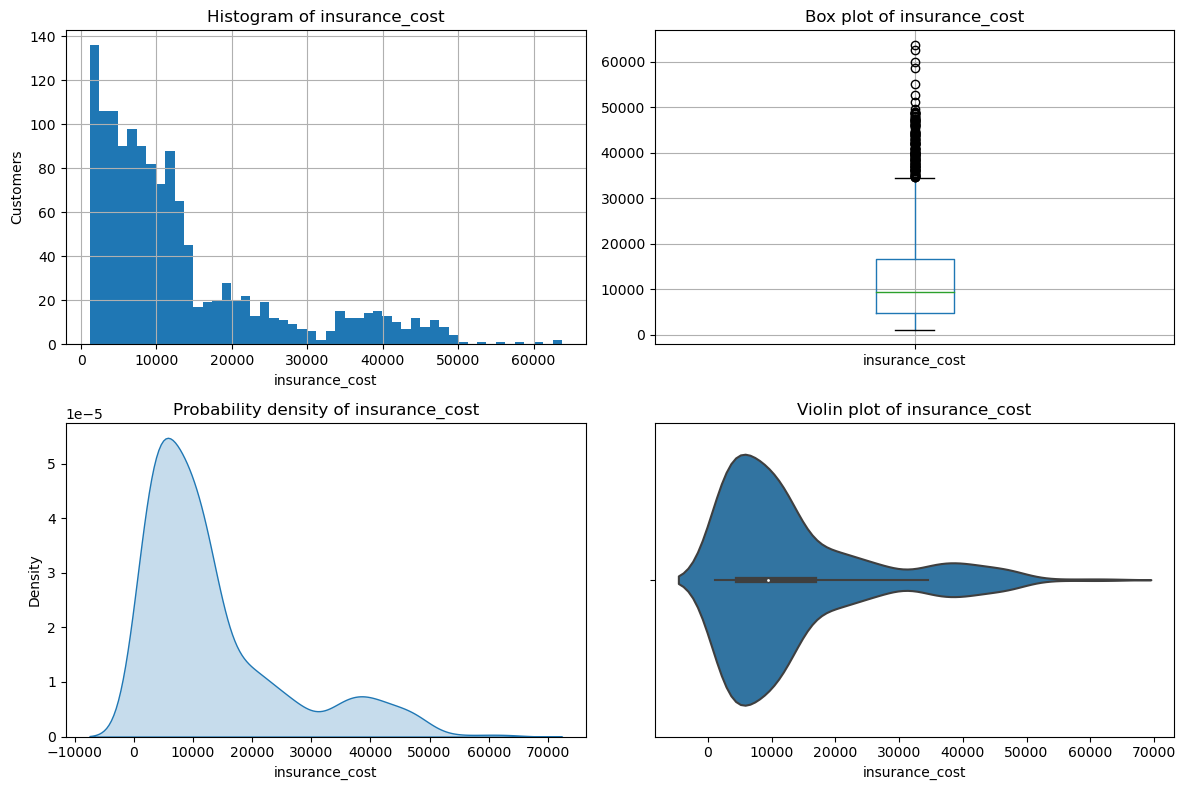

In [28]:
plot_histogram_box_plot_probability_density_violin_plot(df, "insurance_cost")

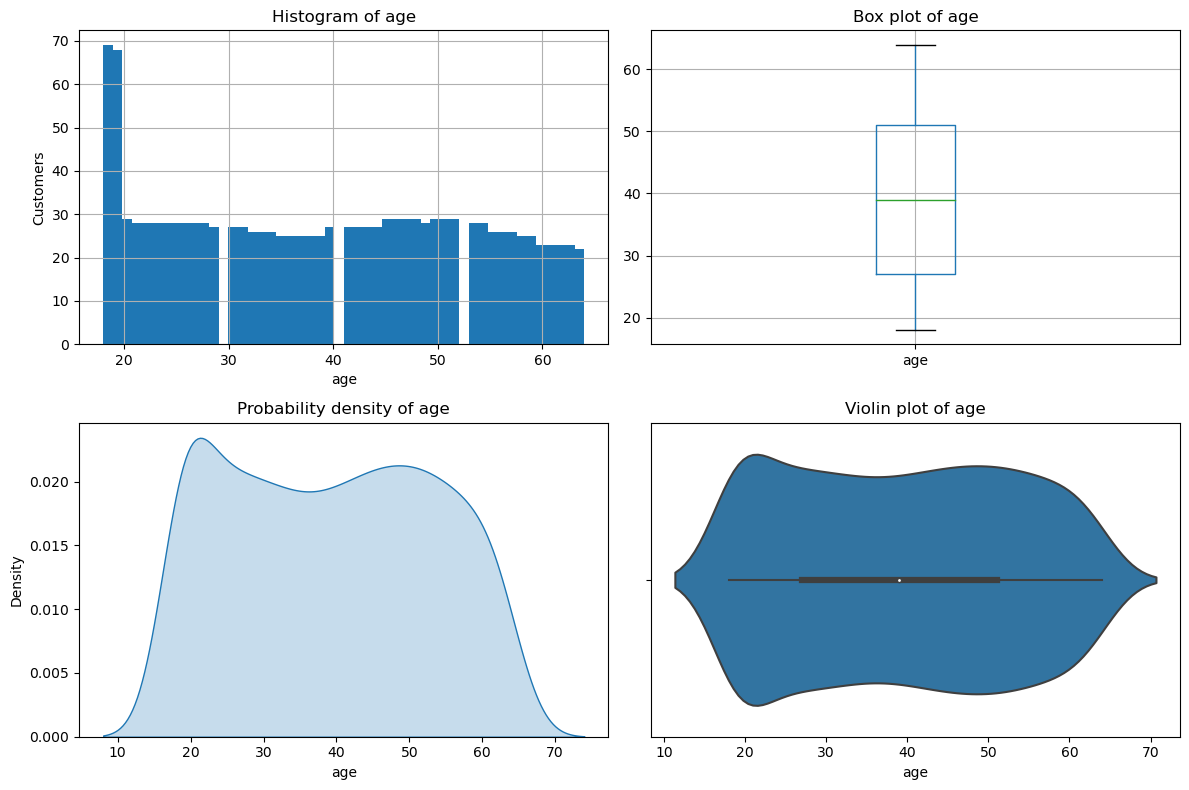

In [29]:
plot_histogram_box_plot_probability_density_violin_plot(df, "age")

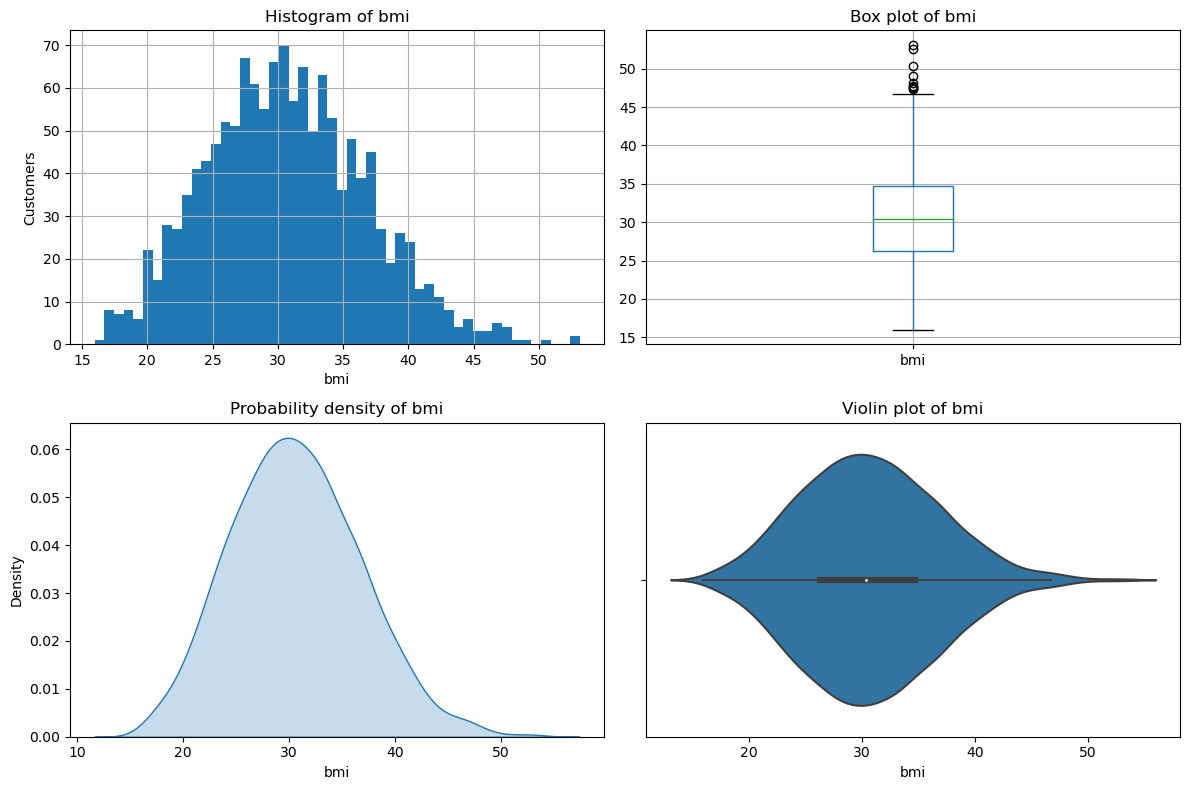

In [30]:
plot_histogram_box_plot_probability_density_violin_plot(df, "bmi")

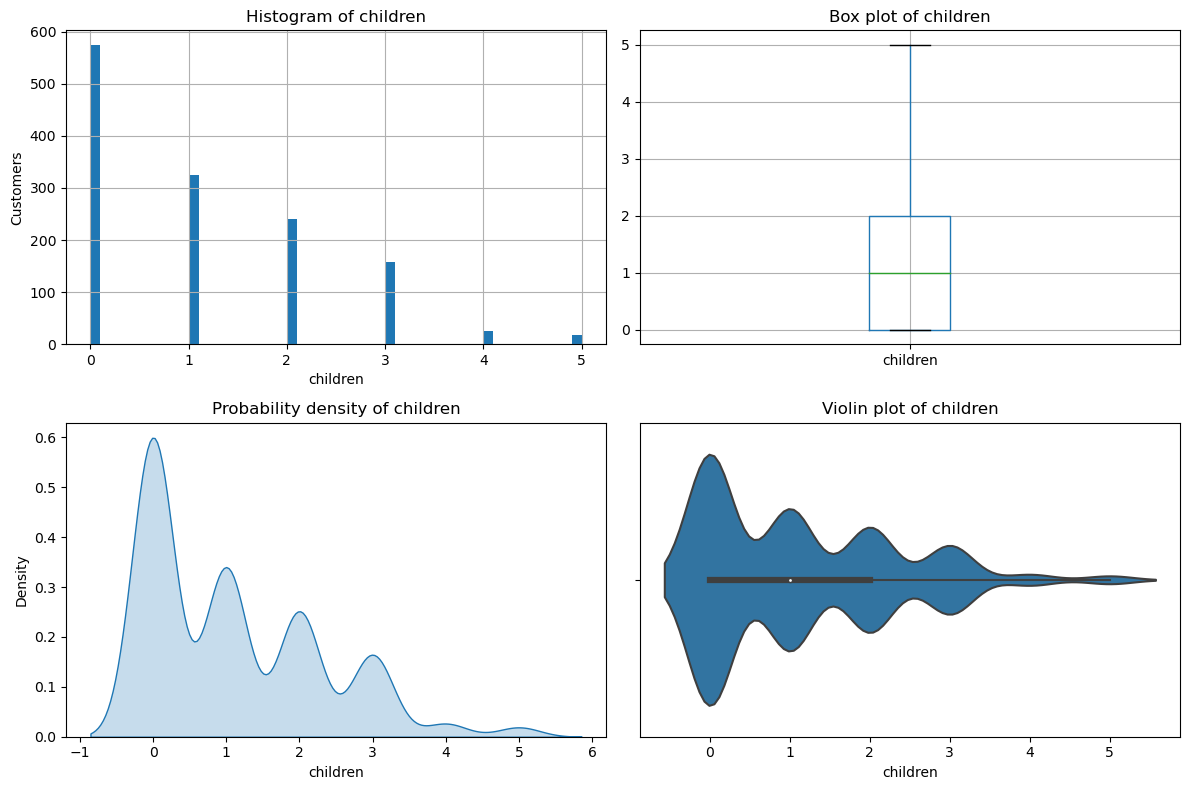

In [31]:
plot_histogram_box_plot_probability_density_violin_plot(df, "children")

#### Distribution Analysis for Categorical Attributes

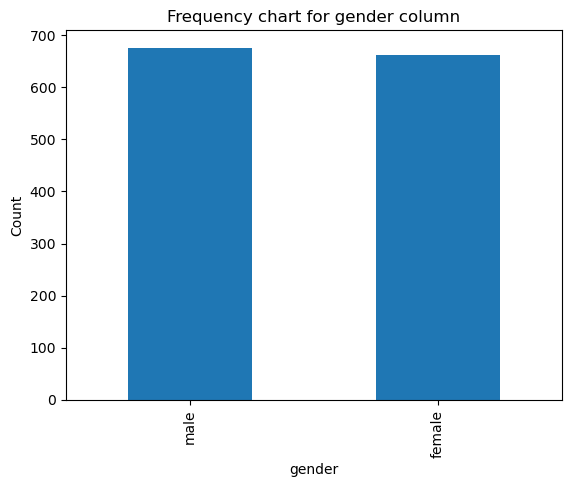

In [32]:
plot_frequency_table_results(df, "gender")

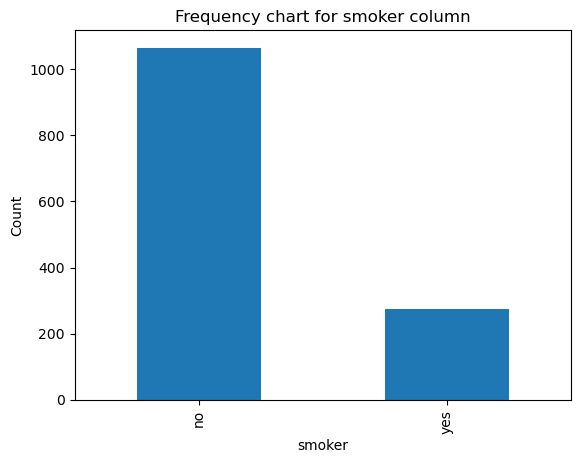

In [33]:
plot_frequency_table_results(df, "smoker")

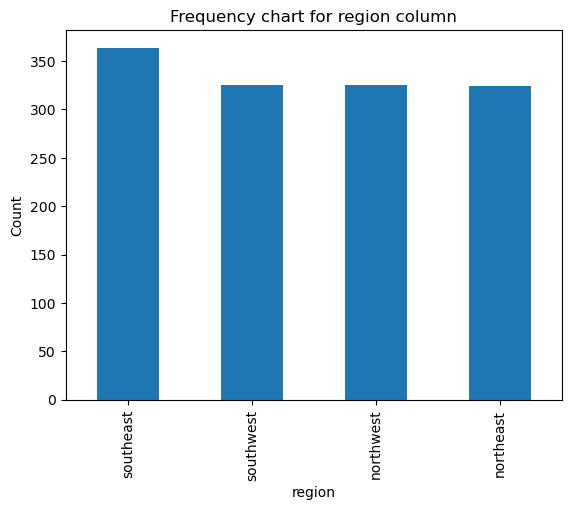

In [34]:
plot_frequency_table_results(df, "region")

### Data Preparation

#### Replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise. 

In [35]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

In [36]:
df["insurance_cost_binary"] = (df["insurance_cost"] > df["insurance_cost"].median()).astype(int)

In [37]:
df.drop(columns=["insurance_cost"], inplace=True)

In [38]:
df.describe()

age          bmi     children  insurance_cost_binary
count  1338.000000  1338.000000  1338.000000            1338.000000
mean     39.207025    30.663397     1.094918               0.500000
std      14.049960     6.098187     1.205493               0.500187
min      18.000000    15.960000     0.000000               0.000000
25%      27.000000    26.296250     0.000000               0.000000
50%      39.000000    30.400000     1.000000               0.500000
75%      51.000000    34.693750     2.000000               1.000000
max      64.000000    53.130000     5.000000               1.000000

In [39]:
df["insurance_cost_binary"].value_counts()

insurance_cost_binary
0    669
1    669
Name: count, dtype: int64

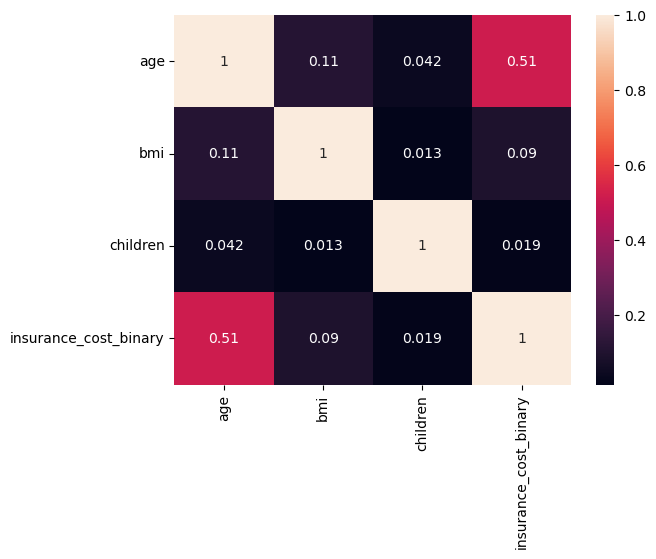

In [40]:
numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns

sns.heatmap(df[numerical_columns].corr(), annot=True);

#### Split data into a target y and predictors X

In [41]:
y = df["insurance_cost_binary"]

In [42]:
X = df.drop("insurance_cost_binary", axis=1)

#### Split the dataset into a training set and a test sets.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

#### Preprocessing pipeline

In [44]:
numeric_features = ["bmi", "age", "children"]

In [45]:
numeric_column_transformer = Pipeline([
    ("scaler", MinMaxScaler())
])

In [46]:
categorical_features = ["gender", "smoker", "region"]

In [47]:
categorical_column_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

In [48]:
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("numeric", numeric_column_transformer, numeric_features),    
        ("categorical", categorical_column_transformer, categorical_features),
    ]
)

#### Confirm that preprocessing pipeline working as expected

In [49]:
df_transformed = preprocess_pipeline.fit_transform(df)

In [50]:
df_transformed_columns = preprocess_pipeline.get_feature_names_out()

In [51]:
df_transformed_data_frame = pd.DataFrame(df_transformed, columns=df_transformed_columns)

In [52]:
df_transformed_data_frame.head()

numeric__bmi  numeric__age  numeric__children  categorical__gender_male  \
0      0.479150           0.0                0.2                       1.0   
1      0.488028           0.0                0.0                       1.0   
2      0.278585           0.0                0.0                       0.0   
3      0.610842           0.0                0.4                       0.0   
4      0.529056           0.0                0.0                       0.0   

   categorical__smoker_yes  categorical__region_northeast  \
0                      0.0                            0.0   
1                      0.0                            0.0   
2                      0.0                            1.0   
3                      0.0                            1.0   
4                      0.0                            1.0   

   categorical__region_northwest  categorical__region_southeast  \
0                            0.0                            1.0   
1                            0.0                            1.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   

   categorical__region_southwest  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0

### Train three classification pipelines with SVM, Random Forest and a third classifier of your choice as the final estimator, respectively, to train a model that predicts the value of `insurance_cost_binary`

- For each classifier, include data preparation and dimensionality reduction steps in the main pipeline.
- You can choose any classifier as the third one. Some options are MLPClassifier, Naive Bayes, and kNN, but you are not limited to them.
- For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
- Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-1 - Binary Classification.ipynb to evaluate and compare the models you have trained and pick the best one.
- Summarise your experience in a markdown cell (max 150 words in a markdown cell).

### SVM

In [53]:
# create the pipeline
pipeline_svm = Pipeline(steps=[
    ("preprocess", preprocess_pipeline), 
    ("reduce_dim", "passthrough"),
    ("svm", svm.SVC(probability=True))
])

#### Visualise the pipeline

In [54]:
set_config(display="diagram")
pipeline_svm

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bmi', 'age', 'children']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', 'passthrough'), ('svm', SVC(probability=True))])

In [55]:
N_FEATURES_OPTIONS = [number_of_features for number_of_features in range(2,9)]

#### Train the model on a variety of hyperparameter configurations

In [56]:
param_grid_svm = [
    {
        "svm__C": [0.1, 1, 10, 100], 
        "svm__gamma": [1, 0.1, 0.01, 0.001], 
        "svm__kernel": ["rbf", "linear", "poly"],
        "reduce_dim": [PCA(iterated_power=7)],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
    },
    {
        "svm__C": [0.1, 1, 10, 100], 
        "svm__gamma": [1, 0.1, 0.01, 0.001], 
        "svm__kernel": ["rbf", "linear", "poly"],
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
    },
    {
        "svm__C": [0.1, 1, 10, 100], 
        "svm__gamma": [1, 0.1, 0.01, 0.001], 
        "svm__kernel": ["rbf", "linear", "poly"],
        "reduce_dim": [RFE(LogisticRegression(),step=5)],
        "reduce_dim__n_features_to_select": N_FEATURES_OPTIONS,
    }
]

In [57]:
search_results_svm = grid_search_with_pipeline(pipeline_svm, param_grid_svm)

In [58]:
svm_best_score, svm_best_params, svm_best_estimator = extract_grid_search_results(search_results_svm)

In [59]:
print("Best CV score = %0.3f:" % svm_best_score)
print("Best parameters: ", svm_best_params)

Best CV score = 0.931:
Best parameters:  {'reduce_dim': SelectKBest(k=6, score_func=<function mutual_info_classif at 0x16432d300>), 'reduce_dim__k': 6, 'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


#### Visualise Results of optimal hyperparameters

In [60]:
pipeline_svm_optimal_params = Pipeline(steps=[
    ("preprocess", preprocess_pipeline), 
    ("reduce_dim", PCA(iterated_power=7, n_components=6)),
    ("reduce_dim_2D", PCA(n_components=2)),
    ("svm", svm.SVC(probability=True, C=10, gamma=1, kernel="rbf"))])

In [62]:
pipeline_svm_optimal_params.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bmi', 'age', 'children']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', PCA(iterated_power=7, n_components=6)),
                ('reduce_dim_2D', PCA(n_components=2)),
                ('svm', SVC(C=10, gamma=1, probability=True))])

In [63]:
explained_variance_ratio = pipeline_svm_optimal_params["reduce_dim"].explained_variance_ratio_

In [64]:
print(explained_variance_ratio)

[0.2009303  0.1892744  0.1834528  0.17905278 0.11693002 0.07003876]


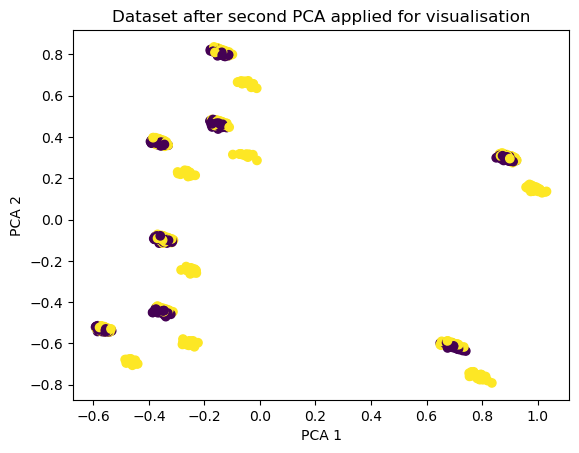

In [65]:
plot_svm_2d_graph(pipeline_svm_optimal_params, X_train, y_train)

In [66]:
pipeline_svm_optimal_params = Pipeline(steps=[
    ("preprocess", preprocess_pipeline), 
    ("reduce_dim", PCA(iterated_power=7, n_components=6)),
    ("svm", svm.SVC(probability=True, C=10, gamma=1, kernel="rbf"))])

In [67]:
pipeline_svm_optimal_params.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bmi', 'age', 'children']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', PCA(iterated_power=7, n_components=6)),
                ('svm', SVC(C=10, gamma=1, probability=True))])

In [68]:
svm_optimal_params_y_pred = pipeline_svm_optimal_params.predict(X_test)

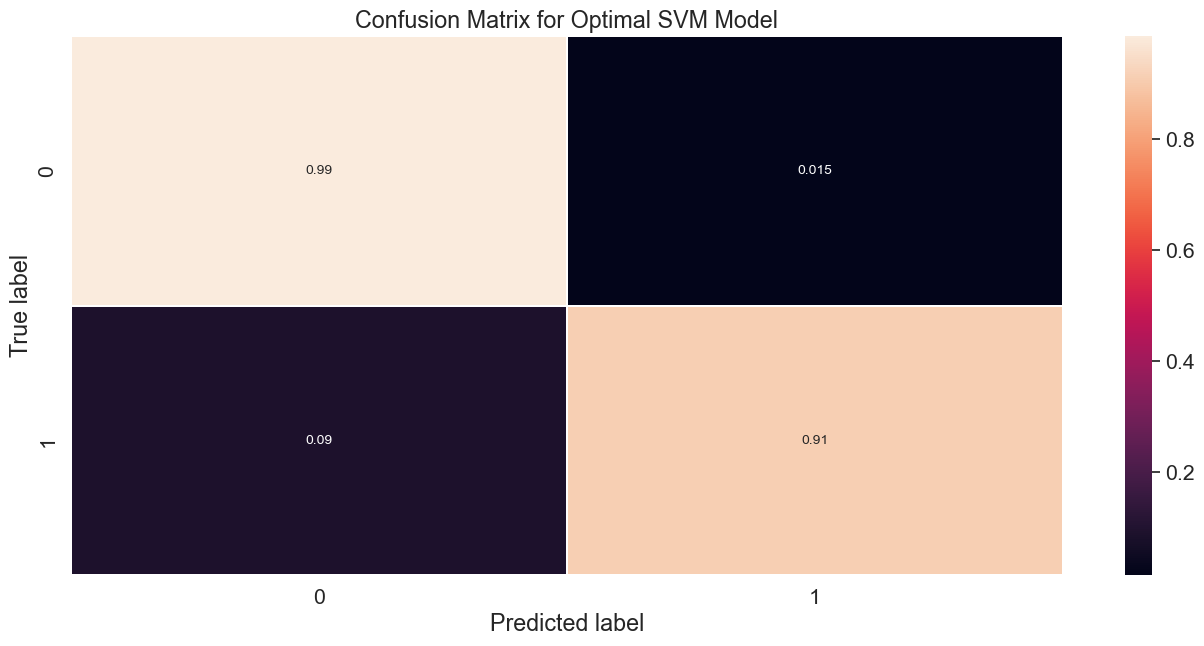

In [69]:
plot_confusion_matrix(y_test, svm_optimal_params_y_pred, "SVM")

In [70]:
SVM_best_params = svm_best_params
SVM_best_model = svm_best_estimator

### Random Forest

In [71]:
# create the pipeline
pipeline_random_forest = Pipeline(steps=[
    ("preprocess", preprocess_pipeline), 
    ("reduce_dim", "passthrough"),
    ("rf", RandomForestClassifier())])

In [72]:
set_config(display="diagram")
pipeline_random_forest

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bmi', 'age', 'children']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', 'passthrough'),
                ('rf', RandomForestClassifier())])

In [73]:
param_grid_random_forest = {
    "rf__n_estimators" : [10,20,30],
    "rf__max_depth": [2, 4, 6, 8]
}

In [74]:
search_results_random_forest = grid_search_with_pipeline(pipeline_random_forest, param_grid_random_forest)

In [75]:
random_forest_best_score, random_forest_best_params, random_forest_best_estimator = extract_grid_search_results(search_results_random_forest)

In [76]:
print("Best CV score = %0.3f:" % random_forest_best_score)
print("Best parameters: ", random_forest_best_params)

Best CV score = 0.933:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 10}


#### Visualise first 5 trees to determine how optimal model is evaluating data

In [77]:
pipeline_random_forest_optimal_params = Pipeline(steps=[
    ("preprocess", preprocess_pipeline), 
    ("reduce_dim", "passthrough"),
    ("rf", RandomForestClassifier(max_depth=8, n_estimators=30))])

In [78]:
pipeline_random_forest_optimal_params.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bmi', 'age', 'children']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', 'passthrough'),
                ('rf', RandomForestClassifier(max_depth=8, n_estimators=30))])

In [79]:
random_forest_optimal_params_model = pipeline_random_forest_optimal_params.named_steps["rf"]

In [80]:
random_forest_optimal_params_model_feature_names = pipeline_random_forest_optimal_params.named_steps["preprocess"].get_feature_names_out()

****************************************************************************************************
Iteration: 1
****************************************************************************************************


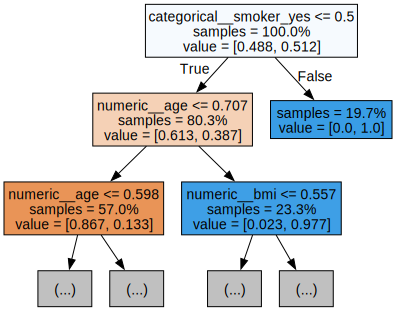

****************************************************************************************************
Iteration: 2
****************************************************************************************************


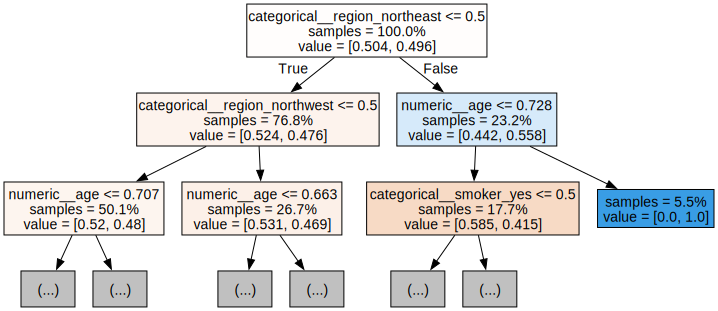

****************************************************************************************************
Iteration: 3
****************************************************************************************************


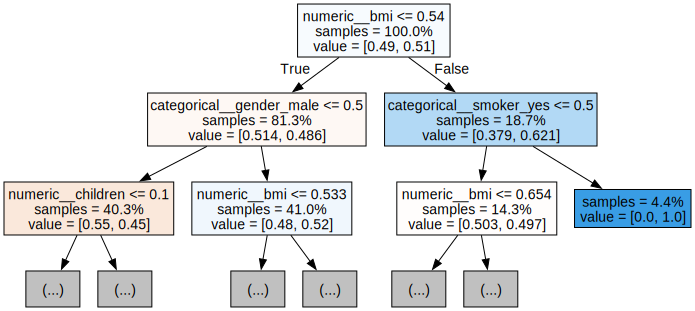

In [81]:
visualise_random_forest_decision_tree(random_forest_optimal_params_model, random_forest_optimal_params_model_feature_names)

In [82]:
# store the best params and best model for later use
RF_best_params = random_forest_best_params
RF_best_model = random_forest_best_estimator

#### Confusion Matrix - Test Performance

In [83]:
random_forest_optimal_params_y_pred = pipeline_random_forest_optimal_params.predict(X_test)

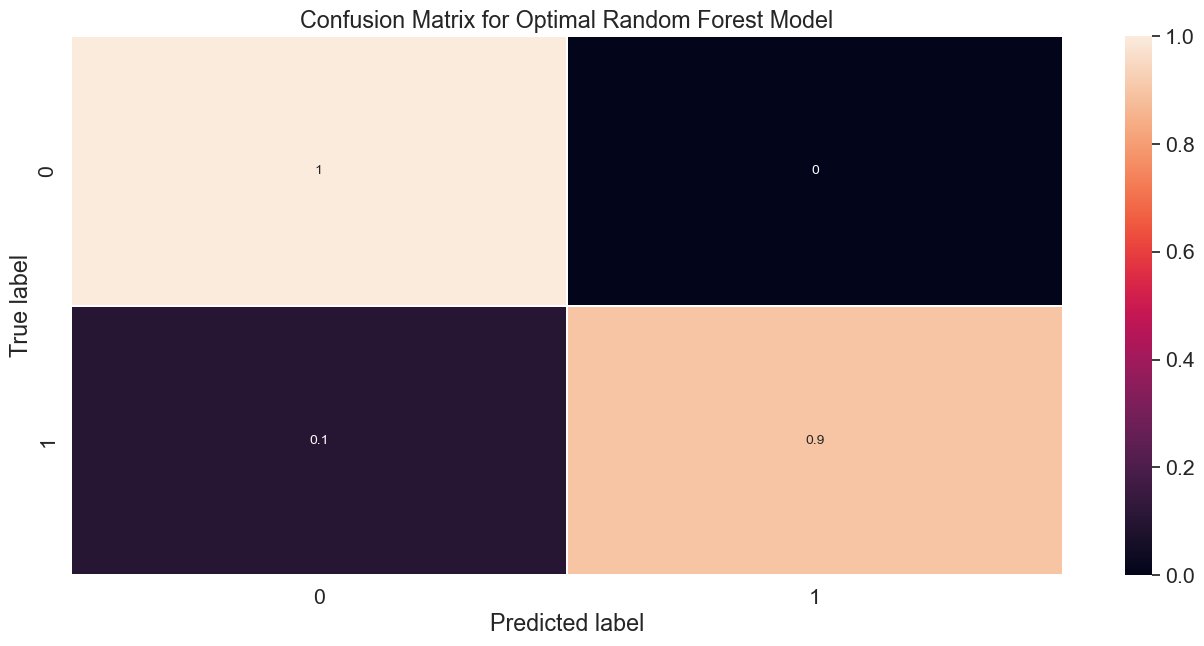

In [84]:
plot_confusion_matrix(y_test, random_forest_optimal_params_y_pred, "Random Forest")

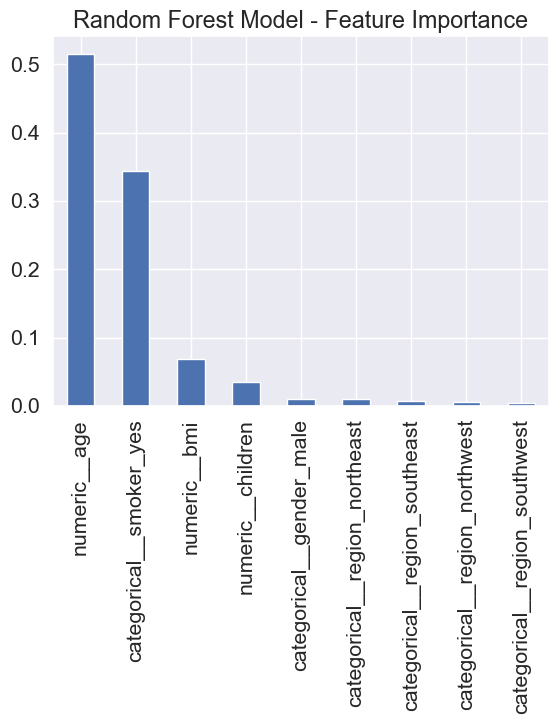

In [85]:
plot_random_forest_model_most_important_features(random_forest_optimal_params_model, random_forest_optimal_params_model_feature_names)

### KNN

In [86]:
# create the pipeline
pipeline_random_knn = Pipeline(steps=[
    ("preprocess", preprocess_pipeline), 
    ("reduce_dim", "passthrough"),
    ("knn", KNeighborsClassifier())])

In [87]:
set_config(display="diagram")
pipeline_random_knn

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bmi', 'age', 'children']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', 'passthrough'),
                ('knn', KNeighborsClassifier())])

In [88]:
param_grid_knn = {
    "knn__n_neighbors" : [3,5,7,9],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1,2]
}

In [89]:
search_results_knn = grid_search_with_pipeline(pipeline_random_knn, param_grid_knn)

In [90]:
knn_best_score, knn_best_params, knn_best_estimator = extract_grid_search_results(search_results_knn)

In [91]:
print("Best CV score = %0.3f:" % knn_best_score)
print("Best parameters: ", knn_best_params)

Best CV score = 0.913:
Best parameters:  {'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}


#### Visualise Performance

In [92]:
pipeline_knn_optimal_params = Pipeline(steps=[
    ("preprocess", preprocess_pipeline), 
    ("reduce_dim", "passthrough"),
    ("knn", KNeighborsClassifier(n_neighbors=5, p=2, weights="distance"))])

In [93]:
pipeline_knn_optimal_params.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bmi', 'age', 'children']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', 'passthrough'),
                ('knn', KNeighborsClassifier(weights='distance'))])

In [94]:
knn_optimal_params_y_pred = pipeline_knn_optimal_params.predict(X_test)

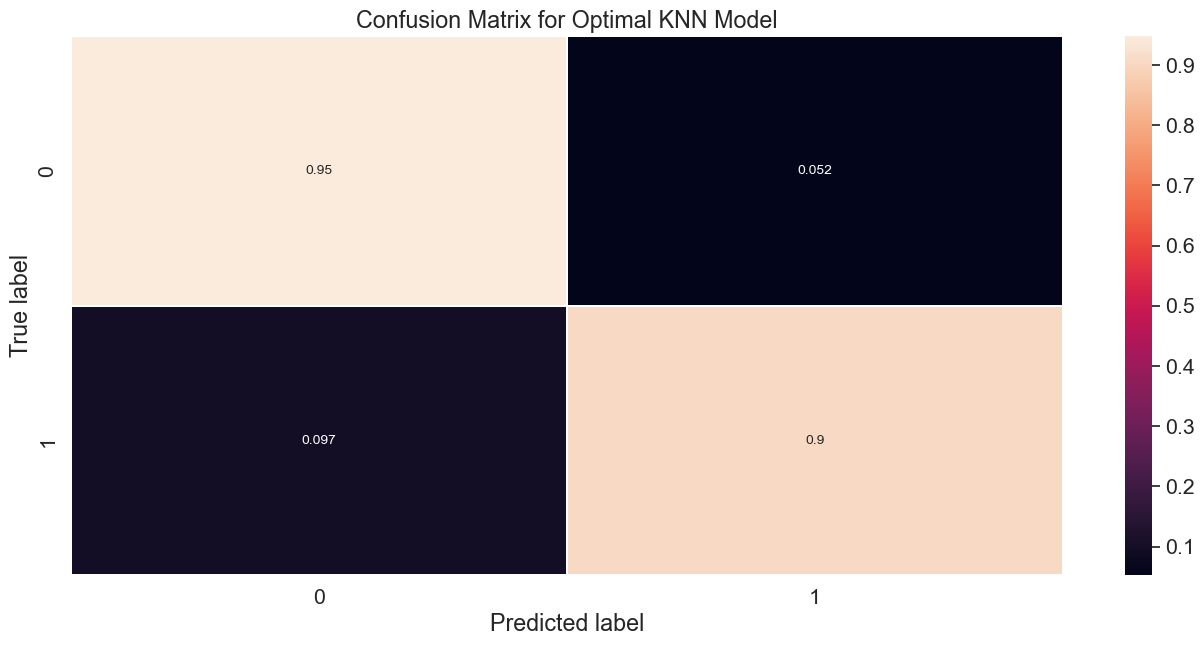

In [95]:
plot_confusion_matrix(y_test, knn_optimal_params_y_pred, "KNN")

In [96]:
# store the best params and best model for later use
KNN_best_params = knn_best_params
KNN_best_model = knn_best_estimator

### Compare Classification Models on Test Set

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline is automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same false positive rate (fpr) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1 and interpolate the true positive rate (tpr) for them.

In [97]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [98]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [99]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)

In [100]:
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

In [101]:
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)

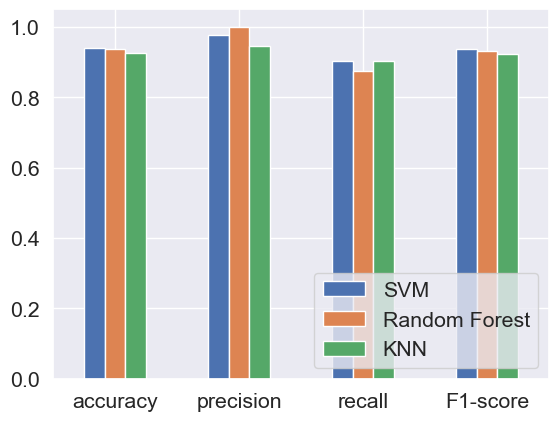

In [102]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])

index = ["accuracy", "precision", "recall", "F1-score"]
df_metrics = pd.DataFrame({"SVM": SVM_metrics, "Random Forest": RF_metrics, "KNN": KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

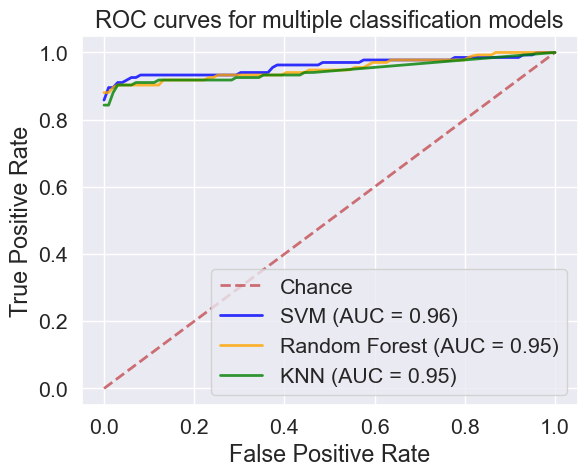

In [103]:
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color="blue", label="SVM (AUC = %0.2f)" % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color="orange", label="Random Forest (AUC = %0.2f)" % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color="green", label="KNN (AUC = %0.2f)" % (RF_auc), alpha=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for multiple classification models")
plt.legend(loc="lower right")
plt.show()

### Train the Final Model

In [104]:
svm_final_model = SVM_best_model.fit(X, y)

In [105]:
filename = "svm_final_model.sav"
pickle.dump(svm_final_model, open(filename, 'wb'))

### Reflection

TODO